<a href="https://colab.research.google.com/github/esalinasbio/taller_REFEP/blob/main/Taller_REFEP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font color='616ACC'>Diseño computacional de proteínas *de novo*</font>**
Este taller se enmarca en lo que actualmente se conoce como el “dogma central del diseño de proteínas”. En este flujo de trabajo, RFDiffusion genera un backbone novedoso que define la forma general de la proteína. A continuación, Protein MPNN propone secuencias de aminoácidos que se adaptan a ese backbone tridimensional de manera estable. Finalmente, AlphaFold valida y refina el modelo, prediciendo con alta precisión la estructura resultante.

De esta manera, el diseño computacional sigue un ciclo lógico:
*   Crear nuevas estructuras proteícas.
*   Diseñar secuencias plausibles
*   Evaluar su viabilidad estructural

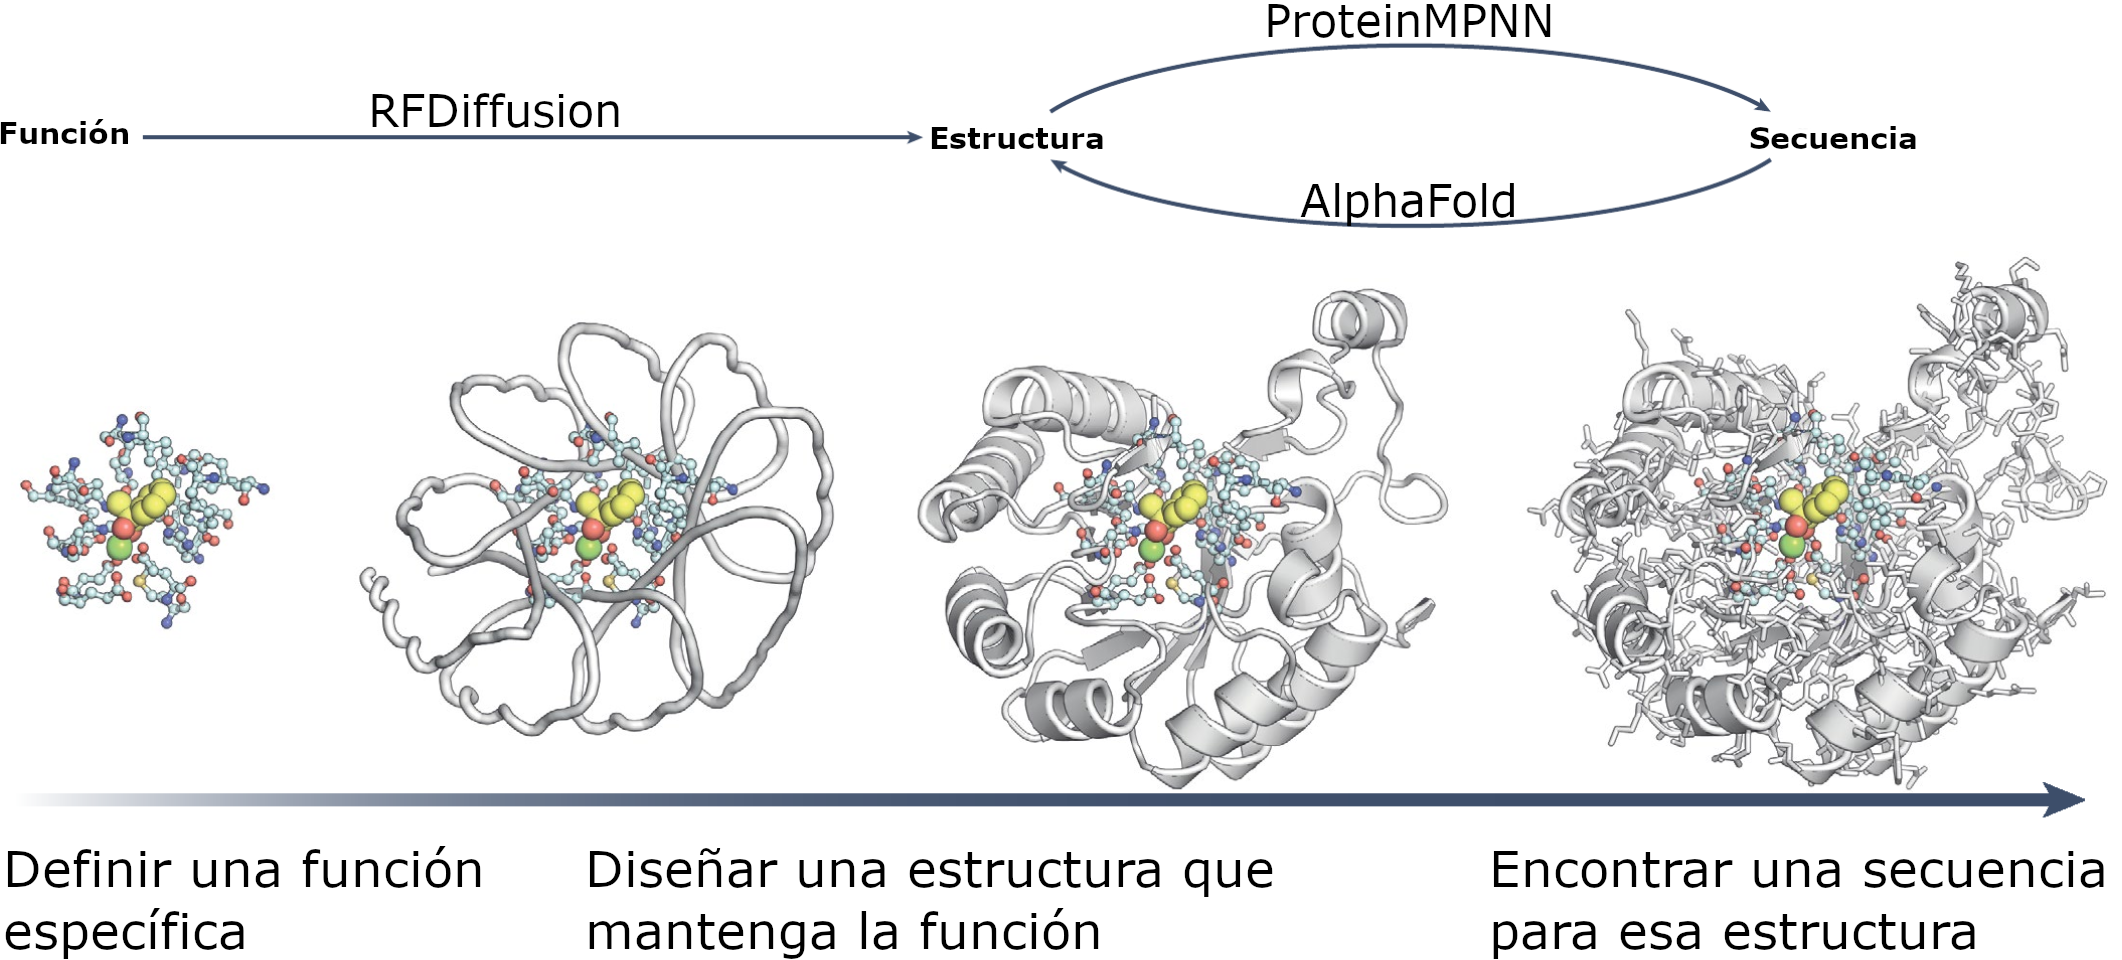

<small>Modificado de Chu, A. E.; Lu, T.; Huang, P.-S. Sparks of Function by de Novo Protein Design. Nat Biotechnol 2024, 42 (2), 203–215. https://doi.org/10.1038/s41587-024-02133-2.</small>




## **<font color='#4FD1C5'> 1. Configuración</font>**
*   Selecciona `Entorno de ejecución` (Runtime) -> `Cambiar tipo de entorno de ejecución` (Runtime type) -> `GPU`
*   `Conectar` en la esquina superior derecha
*   Presiona `Ctrl + S` o usa el menú `Archivo` (`File`) para guardar una copia del notebook a tu Google Drive

Ahora, ejecuta la siguiente celda para instalar y configurar RFDiffusion

In [1]:
#@title Configurar notebook: **RFDiffusion**, **ProteinMPNN** y **Alphafold2** (~2min)
%%time
import os, time, signal
import sys, random, string, re
if not os.path.isdir("params"):
  os.system("apt-get install aria2")
  os.system("mkdir params")
  # send param download into background
  os.system("(\
  aria2c -q -x 16 https://files.ipd.uw.edu/krypton/schedules.zip; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/6f5902ac237024bdd0c176cb93063dc4/Base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/e29311f6f1bf1af907f9ef9f44b8328b/Complex_base_ckpt.pt; \
  aria2c -q -x 16 http://files.ipd.uw.edu/pub/RFdiffusion/f572d396fae9206628714fb2ce00f72e/Complex_beta_ckpt.pt; \
  aria2c -q -x 16 https://storage.googleapis.com/alphafold/alphafold_params_2022-12-06.tar; \
  tar -xf alphafold_params_2022-12-06.tar -C params; \
  touch params/done.txt) &")

if not os.path.isdir("RFdiffusion"):
  print("installing RFdiffusion...")
  os.system("git clone https://github.com/sokrypton/RFdiffusion.git")
  os.system("pip install jedi omegaconf hydra-core icecream pyrsistent pynvml decorator")
  os.system("pip install git+https://github.com/NVIDIA/dllogger#egg=dllogger")
  # 17Mar2024: adding --no-dependencies to avoid installing nvidia-cuda-* dependencies
  # 25Aug2025: updating dgi install to work with latest pytorch
  os.system("pip install --no-dependencies dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html")
  os.system("pip install --no-dependencies e3nn==0.5.5 opt_einsum_fx")
  os.system("cd RFdiffusion/env/SE3Transformer; pip install .")
  os.system("wget -qnc https://files.ipd.uw.edu/krypton/ananas")
  os.system("chmod +x ananas")

if not os.path.isdir("colabdesign"):
  print("installing ColabDesign...")
  os.system("pip -q install git+https://github.com/sokrypton/ColabDesign.git")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabdesign colabdesign")

if not os.path.isdir("RFdiffusion/models"):
  print("downloading RFdiffusion params...")
  os.system("mkdir RFdiffusion/models")
  models = ["Base_ckpt.pt","Complex_base_ckpt.pt","Complex_beta_ckpt.pt"]
  for m in models:
    while os.path.isfile(f"{m}.aria2"):
      time.sleep(5)
  os.system(f"mv {' '.join(models)} RFdiffusion/models")
  os.system("unzip schedules.zip; rm schedules.zip")

if 'RFdiffusion' not in sys.path:
  os.environ["DGLBACKEND"] = "pytorch"
  sys.path.append('RFdiffusion')

from google.colab import files
import json
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import ipywidgets as widgets
import py3Dmol

from inference.utils import parse_pdb
from colabdesign.rf.utils import get_ca
from colabdesign.rf.utils import fix_contigs, fix_partial_contigs, fix_pdb, sym_it
from colabdesign.shared.protein import pdb_to_string
from colabdesign.shared.plot import plot_pseudo_3D

def get_pdb(pdb_code=None):
  if pdb_code is None or pdb_code == "":
    upload_dict = files.upload()
    pdb_string = upload_dict[list(upload_dict.keys())[0]]
    with open("tmp.pdb","wb") as out: out.write(pdb_string)
    return "tmp.pdb"
  elif os.path.isfile(pdb_code):
    return pdb_code
  elif len(pdb_code) == 4:
    if not os.path.isfile(f"{pdb_code}.pdb1"):
      os.system(f"wget -qnc https://files.rcsb.org/download/{pdb_code}.pdb1.gz")
      os.system(f"gunzip {pdb_code}.pdb1.gz")
    return f"{pdb_code}.pdb1"
  else:
    os.system(f"wget -qnc https://alphafold.ebi.ac.uk/files/AF-{pdb_code}-F1-model_v3.pdb")
    return f"AF-{pdb_code}-F1-model_v3.pdb"

def run_ananas(pdb_str, path, sym=None):
  pdb_filename = f"outputs/{path}/ananas_input.pdb"
  out_filename = f"outputs/{path}/ananas.json"
  with open(pdb_filename,"w") as handle:
    handle.write(pdb_str)

  cmd = f"./ananas {pdb_filename} -u -j {out_filename}"
  if sym is None: os.system(cmd)
  else: os.system(f"{cmd} {sym}")

  # parse results
  try:
    out = json.loads(open(out_filename,"r").read())
    results,AU = out[0], out[-1]["AU"]
    group = AU["group"]
    chains = AU["chain names"]
    rmsd = results["Average_RMSD"]
    print(f"AnAnaS detected {group} symmetry at RMSD:{rmsd:.3}")

    C = np.array(results['transforms'][0]['CENTER'])
    A = [np.array(t["AXIS"]) for t in results['transforms']]

    # apply symmetry and filter to the asymmetric unit
    new_lines = []
    for line in pdb_str.split("\n"):
      if line.startswith("ATOM"):
        chain = line[21:22]
        if chain in chains:
          x = np.array([float(line[i:(i+8)]) for i in [30,38,46]])
          if group[0] == "c":
            x = sym_it(x,C,A[0])
          if group[0] == "d":
            x = sym_it(x,C,A[1],A[0])
          coord_str = "".join(["{:8.3f}".format(a) for a in x])
          new_lines.append(line[:30]+coord_str+line[54:])
      else:
        new_lines.append(line)
    return results, "\n".join(new_lines)

  except:
    return None, pdb_str

def run(command, steps, num_designs=1, visual="none"):

  def run_command_and_get_pid(command):
    pid_file = '/dev/shm/pid'
    os.system(f'nohup {command} & echo $! > {pid_file}')
    with open(pid_file, 'r') as f:
      pid = int(f.read().strip())
    os.remove(pid_file)
    return pid
  def is_process_running(pid):
    try:
      os.kill(pid, 0)
    except OSError:
      return False
    else:
      return True

  run_output = widgets.Output()
  progress = widgets.FloatProgress(min=0, max=1, description='running', bar_style='info')
  display(widgets.VBox([progress, run_output]))

  # clear previous run
  for n in range(steps):
    if os.path.isfile(f"/dev/shm/{n}.pdb"):
      os.remove(f"/dev/shm/{n}.pdb")

  pid = run_command_and_get_pid(command)
  try:
    fail = False
    for _ in range(num_designs):

      # for each step check if output generated
      for n in range(steps):
        wait = True
        while wait and not fail:
          time.sleep(0.1)
          if os.path.isfile(f"/dev/shm/{n}.pdb"):
            pdb_str = open(f"/dev/shm/{n}.pdb").read()
            if pdb_str[-3:] == "TER":
              wait = False
            elif not is_process_running(pid):
              fail = True
          elif not is_process_running(pid):
            fail = True

        if fail:
          progress.bar_style = 'danger'
          progress.description = "failed"
          break

        else:
          progress.value = (n+1) / steps
          if visual != "none":
            with run_output:
              run_output.clear_output(wait=True)
              if visual == "image":
                xyz, bfact = get_ca(f"/dev/shm/{n}.pdb", get_bfact=True)
                fig = plt.figure()
                fig.set_dpi(100);fig.set_figwidth(6);fig.set_figheight(6)
                ax1 = fig.add_subplot(111);ax1.set_xticks([]);ax1.set_yticks([])
                plot_pseudo_3D(xyz, c=bfact, cmin=0.5, cmax=0.9, ax=ax1)
                plt.show()
              if visual == "interactive":
                view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
                view.addModel(pdb_str,'pdb')
                view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
                view.zoomTo()
                view.show()
        if os.path.exists(f"/dev/shm/{n}.pdb"):
          os.remove(f"/dev/shm/{n}.pdb")
      if fail:
        progress.bar_style = 'danger'
        progress.description = "failed"
        break

    while is_process_running(pid):
      time.sleep(0.1)

  except KeyboardInterrupt:
    os.kill(pid, signal.SIGTERM)
    progress.bar_style = 'danger'
    progress.description = "stopped"

def run_diffusion(contigs, path, pdb=None, iterations=50,
                  symmetry="none", order=1, hotspot=None,
                  chains=None, add_potential=False, partial_T="auto",
                  num_designs=1, use_beta_model=False, visual="none"):

  full_path = f"outputs/{path}"
  os.makedirs(full_path, exist_ok=True)
  opts = [f"inference.output_prefix={full_path}",
          f"inference.num_designs={num_designs}"]

  if chains == "": chains = None

  # determine symmetry type
  if symmetry in ["auto","cyclic","dihedral"]:
    if symmetry == "auto":
      sym, copies = None, 1
    else:
      sym, copies = {"cyclic":(f"c{order}",order),
                     "dihedral":(f"d{order}",order*2)}[symmetry]
  else:
    symmetry = None
    sym, copies = None, 1

  # determine mode
  contigs = contigs.replace(","," ").replace(":"," ").split()
  is_fixed, is_free = False, False
  fixed_chains = []
  for contig in contigs:
    for x in contig.split("/"):
      a = x.split("-")[0]
      if a[0].isalpha():
        is_fixed = True
        if a[0] not in fixed_chains:
          fixed_chains.append(a[0])
      if a.isnumeric():
        is_free = True
  if len(contigs) == 0 or not is_free:
    mode = "partial"
  elif is_fixed:
    mode = "fixed"
  else:
    mode = "free"

  # fix input contigs
  if mode in ["partial","fixed"]:
    pdb_str = pdb_to_string(get_pdb(pdb), chains=chains)
    if symmetry == "auto":
      a, pdb_str = run_ananas(pdb_str, path)
      if a is None:
        print(f'ERROR: no symmetry detected')
        symmetry = None
        sym, copies = None, 1
      else:
        if a["group"][0] == "c":
          symmetry = "cyclic"
          sym, copies = a["group"], int(a["group"][1:])
        elif a["group"][0] == "d":
          symmetry = "dihedral"
          sym, copies = a["group"], 2 * int(a["group"][1:])
        else:
          print(f'ERROR: the detected symmetry ({a["group"]}) not currently supported')
          symmetry = None
          sym, copies = None, 1

    elif mode == "fixed":
      pdb_str = pdb_to_string(pdb_str, chains=fixed_chains)

    pdb_filename = f"{full_path}/input.pdb"
    with open(pdb_filename, "w") as handle:
      handle.write(pdb_str)

    parsed_pdb = parse_pdb(pdb_filename)
    opts.append(f"inference.input_pdb={pdb_filename}")
    if mode in ["partial"]:
      if partial_T == "auto":
        iterations = int(80 * (iterations / 200))
      else:
        iterations = int(partial_T)
      opts.append(f"diffuser.partial_T={iterations}")
      contigs = fix_partial_contigs(contigs, parsed_pdb)
    else:
      opts.append(f"diffuser.T={iterations}")
      contigs = fix_contigs(contigs, parsed_pdb)
  else:
    opts.append(f"diffuser.T={iterations}")
    parsed_pdb = None
    contigs = fix_contigs(contigs, parsed_pdb)

  if hotspot is not None and hotspot != "":
    hotspot = ",".join(hotspot.replace(","," ").split())
    opts.append(f"ppi.hotspot_res='[{hotspot}]'")

  # setup symmetry
  if sym is not None:
    sym_opts = ["--config-name symmetry", f"inference.symmetry={sym}"]
    if add_potential:
      sym_opts += ["'potentials.guiding_potentials=[\"type:olig_contacts,weight_intra:1,weight_inter:0.1\"]'",
                   "potentials.olig_intra_all=True","potentials.olig_inter_all=True",
                   "potentials.guide_scale=2","potentials.guide_decay=quadratic"]
    opts = sym_opts + opts
    contigs = sum([contigs] * copies,[])

  opts.append(f"'contigmap.contigs=[{' '.join(contigs)}]'")
  opts += ["inference.dump_pdb=True","inference.dump_pdb_path='/dev/shm'"]
  if use_beta_model:
    opts += ["inference.ckpt_override_path=./RFdiffusion/models/Complex_beta_ckpt.pt"]

  print("mode:", mode)
  print("output:", full_path)
  print("contigs:", contigs)

  opts_str = " ".join(opts)
  cmd = f"./RFdiffusion/run_inference.py {opts_str}"
  print(cmd)

  # RUN
  run(cmd, iterations, num_designs, visual=visual)

  # fix pdbs
  for n in range(num_designs):
    pdbs = [f"outputs/traj/{path}_{n}_pX0_traj.pdb",
            f"outputs/traj/{path}_{n}_Xt-1_traj.pdb",
            f"{full_path}_{n}.pdb"]
    for pdb in pdbs:
      with open(pdb,"r") as handle: pdb_str = handle.read()
      with open(pdb,"w") as handle: handle.write(fix_pdb(pdb_str, contigs))

  return contigs, copies

# Visualizing results
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  Ls = get_Ls(contigs)
  xyz, bfact = get_ca(pdb_traj, get_bfact=True)
  xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
  bfact = bfact.reshape((-1,sum(Ls)))[::-1]
  display(HTML(make_animation(xyz, plddt=bfact*100, dpi=300, ref=-1)))

import py3Dmol
def plot_pdb_final(num = "best"):
  if num == "best":
    with open(f"outputs/{path}/best.pdb","r") as f:
      # REMARK 001 design {m} N {n} RMSD {rmsd}
      info = f.readline().strip('\n').split()
    num = info[3]
  hbondCutoff = 4.0
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
  pdb_str = open(f"outputs/{path}_{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
  pdb_str = open(f"outputs/{path}/best_design{num}.pdb",'r').read()
  view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

  view.setStyle({"model":0},{'cartoon':{}}) #: {'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.setStyle({"model":1},{'cartoon':{'colorscheme': {'prop':'b','gradient': 'roygb','min':0,'max':100}}})
  view.zoomTo()
  view.show()

installing RFdiffusion...
installing ColabDesign...
downloading RFdiffusion params...


/content/RFdiffusion/diffusion.py:276: SyntaxWarning: invalid escape sequence '\s'
  Extract \sigma(t) corresponding to chosen sigma schedule.
/content/RFdiffusion/diffusion.py:303: SyntaxWarning: invalid escape sequence '\i'
  sigma(t)^2 := \int_0^t g(s)^2 ds,
/content/RFdiffusion/Track_module.py:241: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


CPU times: user 14.9 s, sys: 1.74 s, total: 16.6 s
Wall time: 3min 19s


## **<font color='#4FD1C5'> 2. Introducción</font>**
El flujo de trabajo junta varias herramientas para diseñar proteínas:

1.   <font color='#F6ADCD'><u>RFDiffusion:</u></font> Permite generar el *backbone* de una proteína mediante eliminación de ruido. Los *backbones* generados son solo "la forma" de la proteína, no tienen aminoácidos.
2.   <font color='#F6ADCD'><u>ProteinMPNN:</u></font> Como los *backbones* no tienen aminoácidos, tenemos que añadirlos con modelos de plegamiento inverso. ProteinMPNN toma las cadenas de glicina (vacias, sin cadenas laterales) y recupera secuencias que se plieguen en la misma estructura tridimensional.
3.   <font color='#F6ADCD'><u>AlphaFold:</u></font> Como ProteinMPNN solo nos da secuencias de aminoácidos, tenemos que verificar que estas secuencias se plieguen como esperamos. Utilizamos alguna de las variantes de AlphaFold para estar seguros de que las nuevas secuencias plegadas se ajusten a nuestro *backbone* original.

## **<font color='#4FD1C5'>3. Difusión no condicionada</font>**
Decirle a RFDiffusion que diseñe un *backbone* aleatorio. Para generarlo, definimos el número de residuos que queremos en el parámetro `contigs`. Por ejemplo, para generar una proteína aleatoria de 99 aminnoácidos, hay que definir `contigs` como 99.

In [ ]:
%%time
#@title Ejecutar diseño no condicional con RFDiiffusion
#@markdown **RFDiffusion** para generar un backbone aleatorio. Reemplaza `contigs` con el número de residuos que desees. `iterations` define cuántos pasos utilizar para quitar el ruido (*denoising*). Puedes aumentar este valor para tener un proceso de difusión más estable, pero más lento.

# Parametros
name = "unconditional"
contigs = "100" #@param {type:"string"}
pdb = ""
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

path = name
# Si ya existe un resultado con este nombre, crea una nueva carpeta para no
# sobreescribir nada
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k, v in flags.items():
  if isinstance(v, str):
    # Arregla comillas
    flags[k] = v.replace("'","").replace('"','')
print(f'Ejecutando RFDiffusion con contigs: {contigs} y {iterations} iterations')
contigs, copies= run_diffusion(**flags)

In [ ]:
#@title Mostrar estructura 3D {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "rainbow" #@param ["rainbow", "chain", "plddt"]
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),
                              alphabet_list,
                              pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':c}})
    else:
      view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':0.5,'max':0.9}}})
    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop': 'backAndForth'})
    view.show()
  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))


if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

### <font color='#F6ADCD'>¿Qué significan las salidas?</font>

Al correr la celda anterior, se generar varios archivos:

1.   Archivo `.pdb`: La predicción final del modelo. Recuerda que el modelo contiene únicamente al *backbone*, no hay cadenas laterales.
2.   Archivo `.trb`: Contiene metadatos asociados con la ejecución. Incluye los `contigs` usados (si específicaste un rango de longitud a explorar), así como la configuración completa usada por RFDiffusion.
3. Trayectorias: Por default, las trayectorias completas se guardan en la carpeta `traj/`. Estos archivos son pdbs que contienen múltiples estados ordenados en reversa, por lo que la primera estructura en cada uno es técnicamente la última (t=1) predicción hecha por RFDiffusion. `pX0` contiene la predicción del modelo en cada paso, y la trayectoria `Xt-1` contiene la entrada al modelo en cada paso.

In [ ]:
# Correr MPNN y AlphaFold2

#@title Diseñar secuencias con **ProteinMPNN**
#@markdown Despues de generar el *backbone*, podemos correr **ProteinMPNN** para encontrar una secuencia que se pliegue en dicha estructura. Se pueden crear múltiples secuencias para el mismo *backbone*. También podemos controlar la diversidad de las secuencias generadas modificando la temperatura del muestreo.
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
temperature = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = 'C'
use_solubleMPNN = False

#@markdown Para validar las nuevas secuencias, podemos utilizar **AlphaFold2**. El backbone original se mostrará en gris, y la estructura de AlphaFold sobrepuesta en color.
initial_guess = False
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12", "20"] {type:"raw"}
use_multimer = False #@param {type:"boolean"}

if not os.path.isfile('params/done.txt'):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={temperature}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Mostrar AF2 output
print('\nResultados AlphaFold')
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

## **<font color='#4FD1C5'> 4. Utilizar motivos como andamios\*</font>**

En el andamiaje, definimos un andamio a partir del cual queremos construir (ej. sito de unión). Podemos utilizar RFDiffusion para diseñar las partes extra. Por ejemplo, `contigs='A163-181/40'` tomará los residuos 163-181 de la cadena A y extenderá 40 residuos en el extremo C-terminal. Estos residuos podrían ser algun sitio activo o de unión que tratamos de estabilizar, tomado de una proteína más grande.

### <font color='#F6ADCD'>**Ejemplo**</font>

En este ejemplo vamos a utilizar como andamio un pépido de p53 que interacciona con Mdm2 (PDB ID: [`1YCR`](https://www.rcsb.org/structure/1YCR)), que es una proteína que regula negativamente al supresor tumoral p53. En el archivo PDB hay 2 cadenas, el fragmento de Mdm2 que interacciona con p53 (A, azul), y dicho fragmento de p53 (B, naranja).



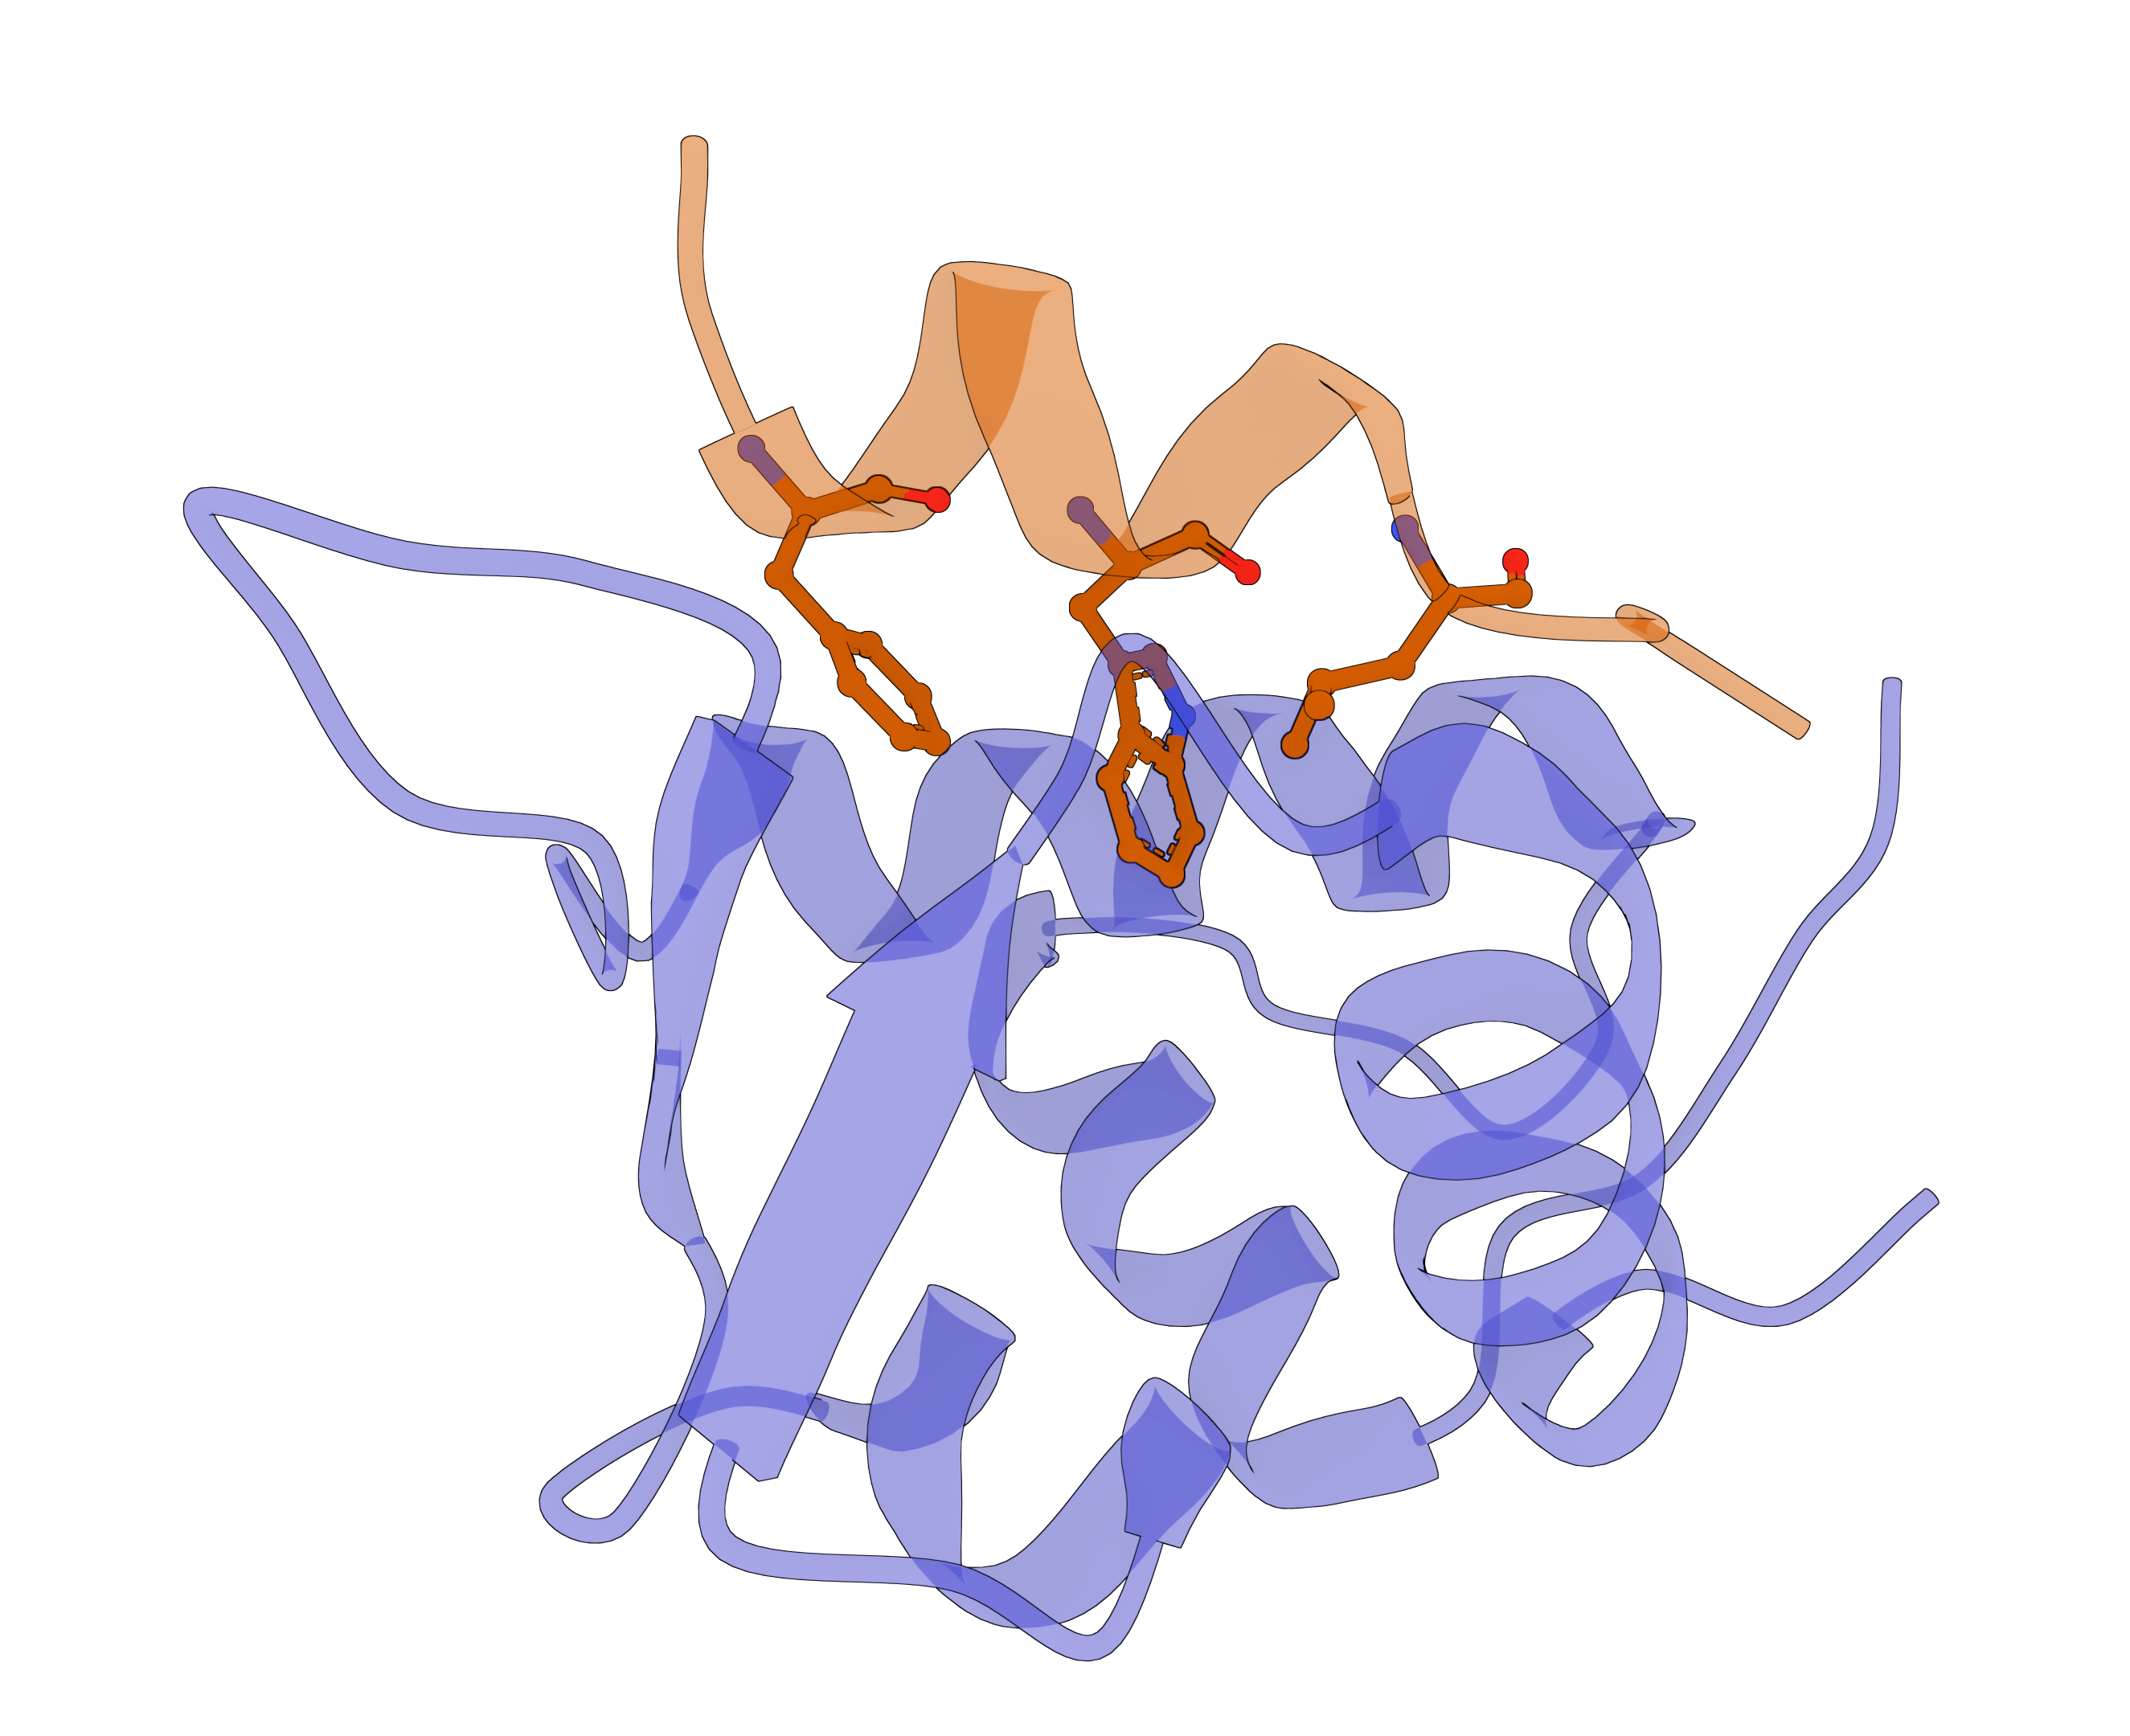

Queremos diseñar un backbone que pueda estabilizar al fragmento de p53 y que pueda unirse a Mdm2, evitando así la inhibición de la actividad de p53.

### <font color='#F6ADCD'>**Ten en cuenta:**</font>
Para `contigs`:
- `:` indica una ruptura de cadena
- `/` para definir múltiples segmentos

***OJO**: Si estuvieramos corriendo cada herramienta por separado tendriamos que añadar instrucciones adicionales a **ProteinMPNN**, para generar solo la secuencia de los residuos que diseñamos con **RFDiffusion**, y no los del andamio/target. En este notebook eso es tomado en cuenta, por lo que las únicas instrucciones con las que hay que jugar son de RFDiffusion*.

In [ ]:
#@title Mostrar estructura original
pdb_id = '1ycr' #@param {type:'string'}

view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
path = get_pdb(pdb_id)
pdb_str = open(path,'r').read()
view.addModel(pdb_str, 'pdb')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd',
          '#d62728', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
chains = sorted({line[21] for line in pdb_str.splitlines() if line.startswith('ATOM')})
for i, chain in enumerate(chains):
    color = colors[i % len(colors)]
    view.setStyle({'chain': chain}, {'cartoon': {'color': color}})
view.zoomTo()
view.show()

In [ ]:
#@title Ejecutar pipeline para *scaffolding*
#@markdown Corre RFDiffusion para utilizar la hélice de p53 (naranja) como andamio para construir un *backbone* nuevo. `lenght` restringe la longitud total del *backbone* generado (min-max).
name = 'motif'
contigs = 'A25-109/0 0-70/B17-29/0-70' #@param {type:'string'}
#length = '70-120' #@param {type:'string'}
pdb = pdb_id
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ''
num_designs = 1 #@param {type:'integer'}
visual = 'interactive'
symmetry = 'none'
order = 1
chains = ''
add_potential = True
partial_T = 'auto'
use_beta_model = False

path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}
         #"length":length}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("Ejecutando difusión")
contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Mostrar estructura 3D {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
show_surface = True #@param {type:"boolean"}
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    # === Color handling ===
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
        view.setStyle({'chain':chain},{'cartoon':{'color':c}})
    else:
      view.setStyle({'cartoon':{'colorscheme':{'prop':'b','gradient':'roygb','min':0.5,'max':0.9}}})

    # === Surface control ===
    if show_surface:
      if color == "chain":
        for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
          view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':c},{'chain':chain})
      else:
        view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':'white'})

    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop':'backAndForth'})
    view.show()

  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))

if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Correr **ProteinMPNN** y **AlphaFold**
#@markdown Ejecuta **ProteinMPNN** para generar nuevas secuencias
num_seqs = 4 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.5 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown **AlphaFold** para validación
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = True #@param {type:"boolean"}

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]

if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("\nResultados AlphaFold")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

## **<font color='#4FD1C5'> 5. Diseño de Binder</font>**

El siguiente objetivo es diseñar un binder completamente nuevo. Las nuevas proteínas de unión se pueden utilizar para examinar diferentes sistemas biológicos interactuando o marcando a otras proteínas, o tambien para desarrollar nuevos tratamientos terapéuticos.

### <font color='#F6ADCD'>Ejemplo</font>
Vamos a diseñar una proteína de unión al receptor de insulina, sin específicar *a priori* la topologíá del binder.

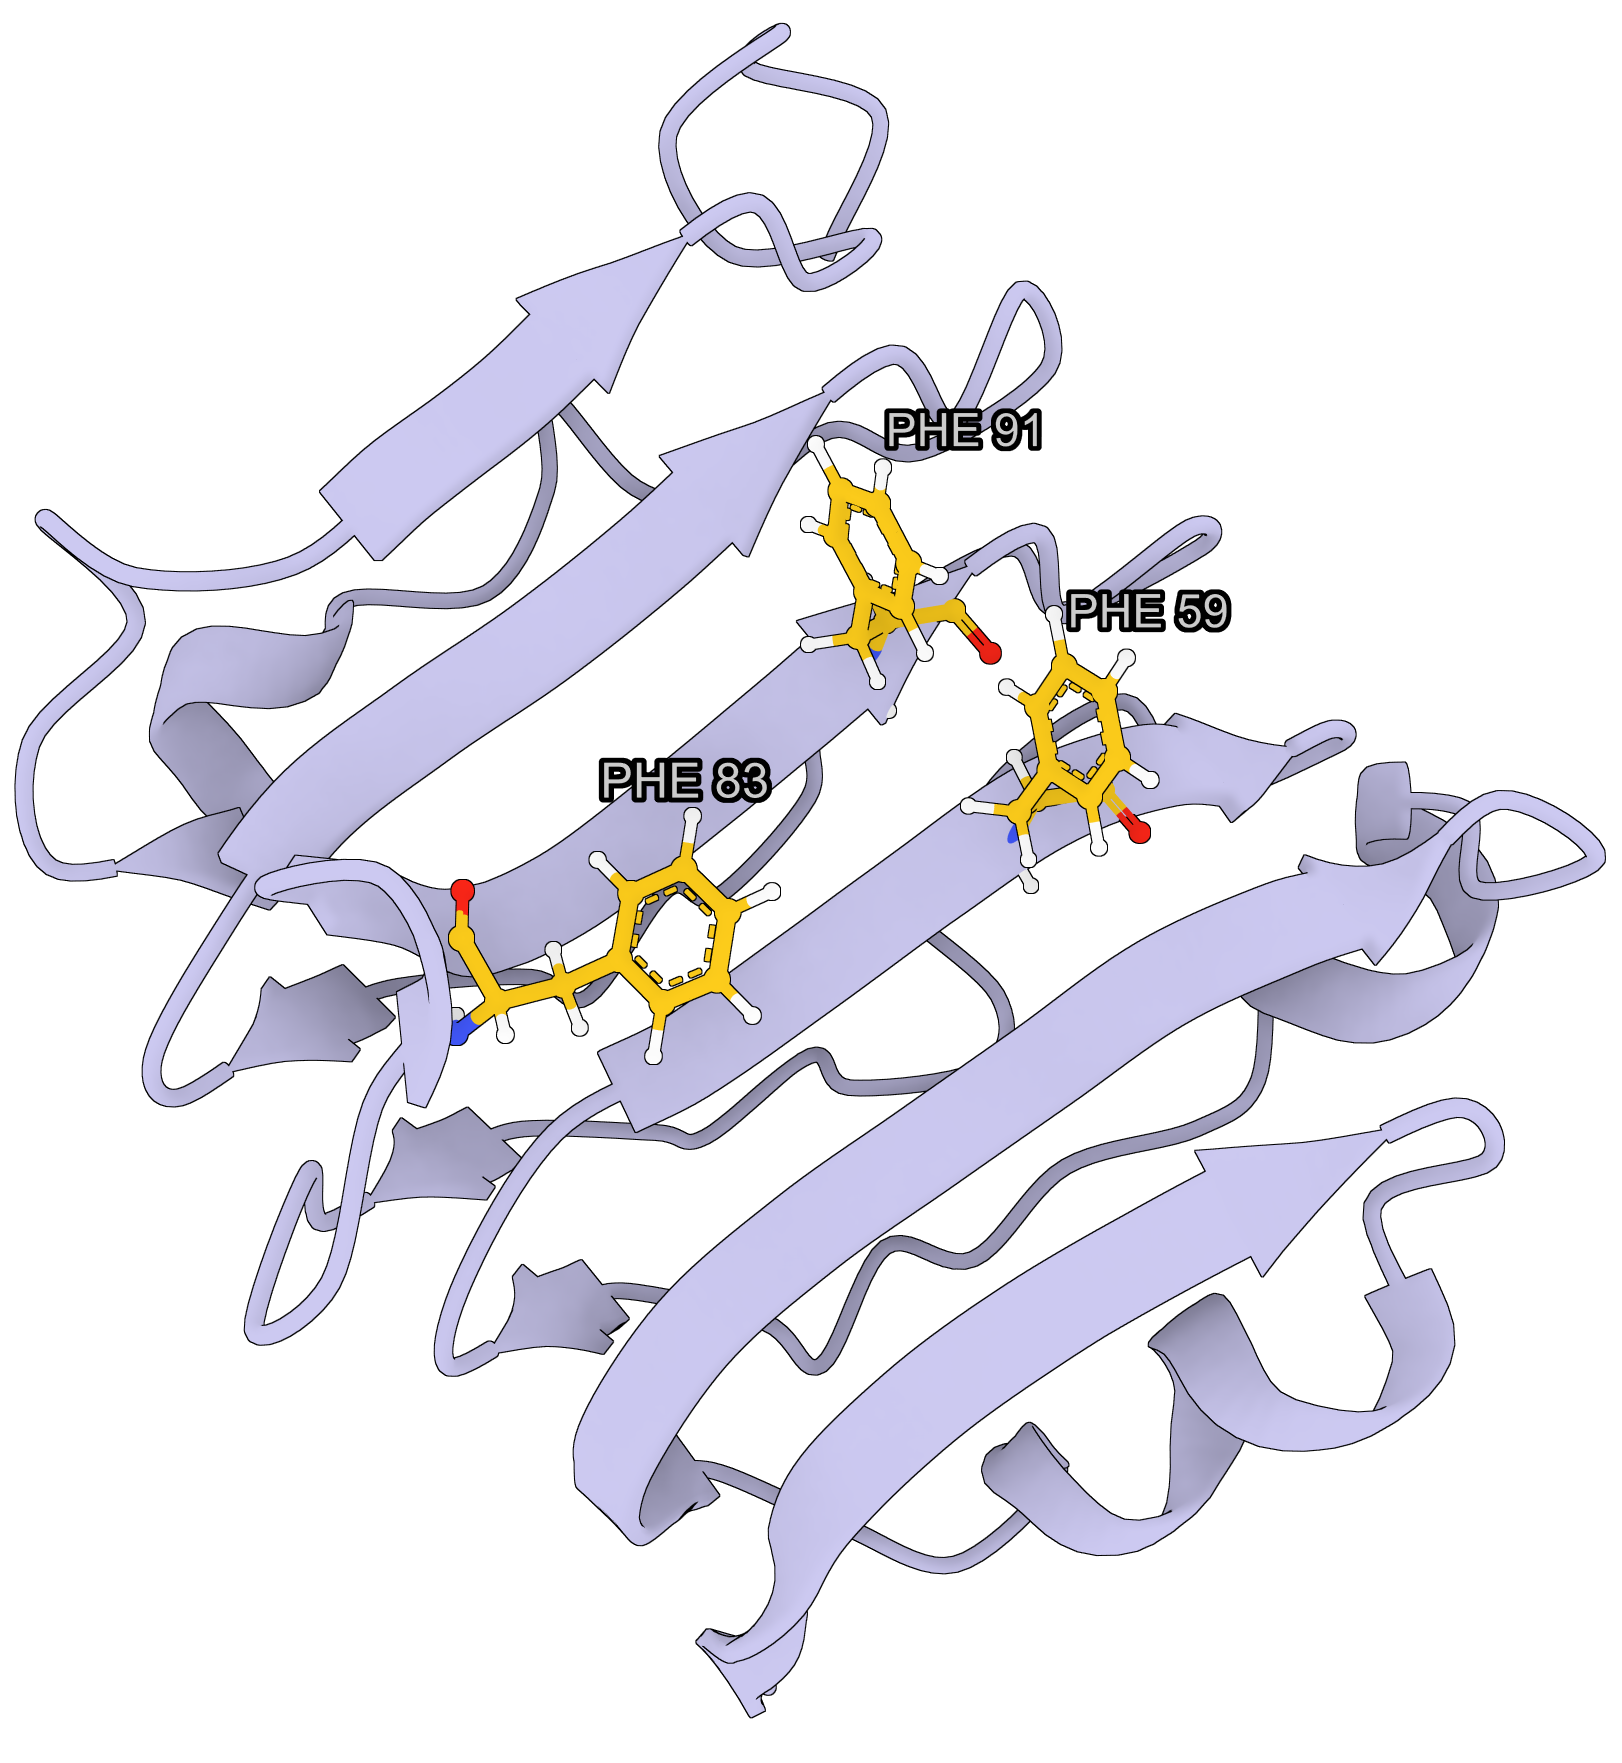

Para esto, rendrás que editar `contigs` para definir una cadena extra de cierta longitud (el nuevo binder), y también editar `hotspot` (amarillos) para específicar areas de contacto entre el receptor de insulina y el nuevo binder.

En este caso, si queremos mantener la cadena A (fragmento del receptor) fija, a su vez que generamos un *backbone* para un binder de entre 70 a 100 residuos que se una a los *hotspots* de los residuos 59, 83 y 91, la configuración se vería así:
- `contigs='A1-150/0 70-100'`
- `hotspot='A59, A83, A91'`

In [ ]:
#@title Mostrar receptor de insulina
view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
path = get_pdb("/content/RFdiffusion/examples/input_pdbs/insulin_target.pdb")
pdb_str = open(path,'r').read()
view.addModel(pdb_str, 'pdb')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd',
          '#d62728', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf']
chains = sorted({line[21] for line in pdb_str.splitlines() if line.startswith('ATOM')})
for i, chain in enumerate(chains):
    color = colors[i % len(colors)]
    view.setStyle({'chain': chain}, {'cartoon': {'color': color}})
for resi in [59, 83, 91]:
    view.setStyle({'resi': str(resi)}, {'stick': {}, 'cartoon': {'color': color}})
view.zoomTo()
view.show()

In [ ]:
%%time
#@title Ejecutar **RFDiffusion** para diseño de binder
#@markdown Descripción aquí
name = "binder"
contigs = "A1-150/0 70-100" #@param {type:"string"}
use_provided = True #@param {type:"boolean"}
if (use_provided):
  pdb = "/content/RFdiffusion/examples/input_pdbs/insulin_target.pdb"
else:
  pdb = "" #@param {type:"string"}
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "A59, A83, A91" #@param {type:"string"}
num_designs = 1
visual = "interactive"
symmetry = "none"
order = 1
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Mostrar estructura 3D {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "plddt" #@param ["rainbow", "chain", "plddt"]
show_surface = True #@param {type:"boolean"}
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    # === Color handling ===
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
        view.setStyle({'chain':chain},{'cartoon':{'color':c}})
    else:
      view.setStyle({'cartoon':{'colorscheme':{'prop':'b','gradient':'roygb','min':0.5,'max':0.9}}})

    # === Surface control ===
    if show_surface:
      if color == "chain":
        for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
          view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':c},{'chain':chain})
      else:
        view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':'white'})

    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop':'backAndForth'})
    view.show()

  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))

if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Correr **ProteinMPNN** y **AlphaFold**
#@markdown Ejecuta **ProteinMPNN** para generar nuevas secuencias
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 1.0 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown **AlphaFold** para validación
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = True #@param {type:"boolean"}

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]

if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("\nResultados AlphaFold")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

## **<font color='#4FD1C5'> 5. Simetría</font>**

En este ejemplo, vamos a generar un oligomero con simetría C6, con 6 cadenas de 80 residuos cada una


In [ ]:
%%time
#@title Ejecutar **RFDiffusion** para diseño de binder
#@markdown Descripción aquí
name = "symmetry"
contigs = "80" #@param {type:"string"}
pdb = ""
iterations = 25 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = ""
num_designs = 1
visual = "interactive"
symmetry = "cyclic" #@param ["none", "auto", "cyclic", "dihedral"]
order = 6 #@param ["1", "2", "3", "4", "5", "6"] {type:"raw"}
chains = ""
add_potential = True
partial_T = "auto"
use_beta_model = False

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')
print("RUNNING RFDIFFUSION")
contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Mostrar estructura 3D {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "plddt" #@param ["rainbow", "chain", "plddt"]
show_surface = True #@param {type:"boolean"}
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    # === Color handling ===
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
        view.setStyle({'chain':chain},{'cartoon':{'color':c}})
    else:
      view.setStyle({'cartoon':{'colorscheme':{'prop':'b','gradient':'roygb','min':0.5,'max':0.9}}})

    # === Surface control ===
    if show_surface:
      if color == "chain":
        for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
          view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':c},{'chain':chain})
      else:
        view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':'white'})

    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop':'backAndForth'})
    view.show()

  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))

if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
#@title Correr **ProteinMPNN** y **AlphaFold**
#@markdown Ejecuta **ProteinMPNN** para generar nuevas secuencias
num_seqs = 1 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C"
use_solubleMPNN = False

#@markdown **AlphaFold** para validación
num_recycles = 2 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
use_multimer = False #@param {type:"boolean"}

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]

if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("\nResultados AlphaFold")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()

## **<font color='#4FD1C5'> 6. Ejemplos e instrucciones</font>**
---

Utiliza `contigs` para definir cadenas contiguas. Usa `:` para definir multiples contigs, y `/` para definir multiples segmentos dentro de un contig. Por ejemplo:

**no condicional**
- `contigs='100'` - difunde un monomero de longitud 100.
- `contigs='50-100'` - diseña monomero de entre 50 a 100 residuos.
- `contigs='50:100'` - diseña hetero-oligomero de longitudes 50 y 100.

**diseño *binder***
- `contigs='A:50'` `pdb='4N5T'` - diseña un **binder** de longitud 50 a la cadena A del PDB especificado.
- `contigs='E6-155:70-100'` `pdb='5KQV'` `hotspot='E64,E88,E96'` - difunde un **binder** de longitud 70 a 100 (aleatorio) a la cadena E y los *hotspots* definidos.

**andamiaje**
 - `contigs='40/A163-181/40'` `pdb='5TPN'` - Usa los residuos 163-181 de la cadena A como andamio, y difunde dos segmentos de 40 residuos a cada extremo.
 - `contigs='A3-30/36/A33-68'` `pdb='6MRR'` - difunde un loop de longitud 36 entre los dos segmentos definidos.

**difusión parcial**
- `contigs=''` `pdb='6MRR'` - añade ruido a todas las coordenadas del PDB.
- `contigs='A1-10'` `pdb='6MRR'` - mantiene las 10 primeras posiciones fijas, añade ruido a lo demás.
- `contigs='A'` `pdb='1SSC'` - fija cadena A, añade ruido al resto.

*Consejos*
- `pdb=''` deja vacío para que te de la opción de cargar un archivo PDB
- `contigs='50-100'` usa un guión para especificar un rango

*ejemplos*

Difusión no condicional: `contigs='100'`,`iterations=any`

Andamiaje: `contigs='A1-29/5-5/A98-126 : A30-97'`, `pdb=6w70`, `iterations=any`

Binder: `contigs='A1-63:B1-68:100-100'`, `hotspots=B58, A41, B56, A44`


## **<font color='#4FD1C5'>6. Ejercicios</font>**

In [ ]:
%%time
#@title Correr **RFdiffusion** para generar un *backbone*
name = "test" #@param {type:"string"}
contigs = "100" #@param {type:"string"}
pdb = "" #@param {type:"string"}
iterations = 50 #@param ["25", "50", "100", "150", "200"] {type:"raw"}
hotspot = "" #@param {type:"string"}
num_designs = 1 #@param ["1", "2", "4", "8", "16", "32"] {type:"raw"}
visual = "image" #@param ["none", "image", "interactive"]
#@markdown ---
#@markdown Configurar simetría
#@markdown ---
symmetry = "none" #@param ["none", "auto", "cyclic", "dihedral"]
order = 1 #@param ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"] {type:"raw"}
chains = "" #@param {type:"string"}
add_potential = True #@param {type:"boolean"}
#@markdown - `symmetry='auto'` activa la detección automática de simetria con [AnAnaS](https://team.inria.fr/nano-d/software/ananas/).
#@markdown - `chains="A,B"` Filtra estas cadenas del PDB (puede ayudarle a AnAnaS)
#@markdown - `add_potential` previene choques entre cadenas
#@markdown ---
#@markdown Configuración avanzada
#@markdown ---
partial_T = "auto" # @param ["auto", "10", "20", "40", "60", "80"]
#@markdown - Especifica el número de pasos (solo para la difusión parcial)
use_beta_model = False #@param {type:"boolean"}
#@markdown - si ves muchas hélices (y no te gusta), cambia a los parámetros "beta" para mejor valance de estructuras secundarias

# determine where to save
path = name
while os.path.exists(f"outputs/{path}_0.pdb"):
  path = name + "_" + ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))

flags = {"contigs":contigs,
         "pdb":pdb,
         "order":order,
         "iterations":iterations,
         "symmetry":symmetry,
         "hotspot":hotspot,
         "path":path,
         "chains":chains,
         "add_potential":add_potential,
         "num_designs":num_designs,
         "use_beta_model":use_beta_model,
         "visual":visual,
         "partial_T":partial_T}

for k,v in flags.items():
  if isinstance(v,str):
    flags[k] = v.replace("'","").replace('"','')

contigs, copies = run_diffusion(**flags)

In [ ]:
#@title Mostrar estructura 3D {run: "auto"}
animate = "none" #@param ["none", "movie", "interactive"]
color = "chain" #@param ["rainbow", "chain", "plddt"]
show_surface = False #@param {type:"boolean"}
denoise = True
dpi = 100 #@param ["100", "200", "400"] {type:"raw"}
from colabdesign.shared.plot import pymol_color_list
from colabdesign.rf.utils import get_ca, get_Ls, make_animation
from string import ascii_uppercase,ascii_lowercase
alphabet_list = list(ascii_uppercase+ascii_lowercase)

def plot_pdb(num=0):
  if denoise:
    pdb_traj = f"outputs/traj/{path}_{num}_pX0_traj.pdb"
  else:
    pdb_traj = f"outputs/traj/{path}_{num}_Xt-1_traj.pdb"
  if animate in ["none","interactive"]:
    hbondCutoff = 4.0
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    if animate == "interactive":
      pdb_str = open(pdb_traj,'r').read()
      view.addModelsAsFrames(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})
    else:
      pdb = f"outputs/{path}_{num}.pdb"
      pdb_str = open(pdb,'r').read()
      view.addModel(pdb_str,'pdb',{'hbondCutoff':hbondCutoff})

    # === Color handling ===
    if color == "rainbow":
      view.setStyle({'cartoon': {'color':'spectrum'}})
    elif color == "chain":
      for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
        view.setStyle({'chain':chain},{'cartoon':{'color':c}})
    else:
      view.setStyle({'cartoon':{'colorscheme':{'prop':'b','gradient':'roygb','min':0.5,'max':0.9}}})

    # === Surface control ===
    if show_surface:
      if color == "chain":
        for n,chain,c in zip(range(len(contigs)),alphabet_list,pymol_color_list):
          view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':c},{'chain':chain})
      else:
        view.addSurface(py3Dmol.SAS,{'opacity':0.4,'color':'white'})

    view.zoomTo()
    if animate == "interactive":
      view.animate({'loop':'backAndForth'})
    view.show()

  else:
    Ls = get_Ls(contigs)
    xyz, bfact = get_ca(pdb_traj, get_bfact=True)
    xyz = xyz.reshape((-1,sum(Ls),3))[::-1]
    bfact = bfact.reshape((-1,sum(Ls)))[::-1]
    if color == "chain":
      display(HTML(make_animation(xyz, Ls=Ls, dpi=dpi, ref=-1)))
    elif color == "rainbow":
      display(HTML(make_animation(xyz, dpi=dpi, ref=-1)))
    else:
      display(HTML(make_animation(xyz, plddt=bfact*100, dpi=dpi, ref=-1)))

if num_designs > 1:
  output = widgets.Output()
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb(change['new'])
  dropdown = widgets.Dropdown(
      options=[(f'{k}',k) for k in range(num_designs)],
      value=0, description='design:',
  )
  dropdown.observe(on_change)
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb(dropdown.value)
else:
  plot_pdb()

In [ ]:
%%time
#@title Correr **ProteinMPNN** para generar secuencias y **AlphaFold** para validar
#@markdown ProteinMPNN
num_seqs = 8 #@param ["1", "2", "4", "8", "16", "32", "64"] {type:"raw"}
mpnn_sampling_temp = 0.1 #@param ["0.0001", "0.1", "0.15", "0.2", "0.25", "0.3", "0.5", "1.0"] {type:"raw"}
rm_aa = "C" #@param {type:"string"}
use_solubleMPNN = False #@param {type:"boolean"}
#@markdown - `mpnn_sampling_temp` - controla la diversidad de secuencias (mayor = mas diversas)
#@markdown - `rm_aa='C'` - No utilizar algunos aminoácidos ([C]isteina).
#@markdown - `use_solubleMPNN` - usar modelo entrenado solo con proteínas solubles. Ver [preprint](https://www.biorxiv.org/content/10.1101/2023.05.09.540044v2).
#@markdown
#@markdown AlphaFold
initial_guess = False #@param {type:"boolean"}
#@markdown - utilizar iniciación suave, ver [paper](https://www.nature.com/articles/s41467-023-38328-5).
num_recycles = 1 #@param ["0", "1", "2", "3", "6", "12"] {type:"raw"}
#@markdown - para diseñar **binders**, se recomienda `initial_guess=True num_recycles=3`
use_multimer = False #@param {type:"boolean"}
#@markdown - `use_multimer` - usar parámetros de AlphaFold Multimer v3 para la predicción.

if not os.path.isfile("params/done.txt"):
  print("downloading AlphaFold params...")
  while not os.path.isfile("params/done.txt"):
    time.sleep(5)

contigs_str = ":".join(contigs)
opts = [f"--pdb=outputs/{path}_0.pdb",
        f"--loc=outputs/{path}",
        f"--contig={contigs_str}",
        f"--copies={copies}",
        f"--num_seqs={num_seqs}",
        f"--num_recycles={num_recycles}",
        f"--rm_aa={rm_aa}",
        f"--mpnn_sampling_temp={mpnn_sampling_temp}",
        f"--num_designs={num_designs}"]
if initial_guess: opts.append("--initial_guess")
if use_multimer: opts.append("--use_multimer")
if use_solubleMPNN: opts.append("--use_soluble")
opts = ' '.join(opts)
!python colabdesign/rf/designability_test.py {opts}

# Show Alphafold output
print("\nResultados AlphaFold")
if num_designs > 1:
  def on_change(change):
    if change['name'] == 'value':
      with output:
        output.clear_output(wait=True)
        plot_pdb_final(change['new'])
  dropdown = widgets.Dropdown(
    options=["best"] + [str(k) for k in range(num_designs)],
    value="best",
    description='design:',
  )
  dropdown.observe(on_change)
  output = widgets.Output()
  display(widgets.VBox([dropdown, output]))
  with output:
    plot_pdb_final(dropdown.value)
else:
  plot_pdb_final()